In [36]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [37]:
!pip install pandas
import pandas as pd
df = pd.read_csv('./data_cleaning.csv',sep=';')
#df = df.drop(columns=['index'])
df["ncm"] = df["ncm"].astype(str)
for i in range(len(df)):
  if len(df["ncm"].iloc[i]) < 8:
    df["ncm"].iloc[i] = "0"+ df["ncm"].iloc[i]
df['ncm_in'] = df['ncm'].astype(str).str[:4]
df['ncm_out'] = df['ncm'].astype(str).str[4:6]
df = df.drop(columns=['Unnamed: 0','ncm'])

df = df.dropna()

C:\Users\Pedro\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<AxesSubplot:xlabel='ncm_out'>

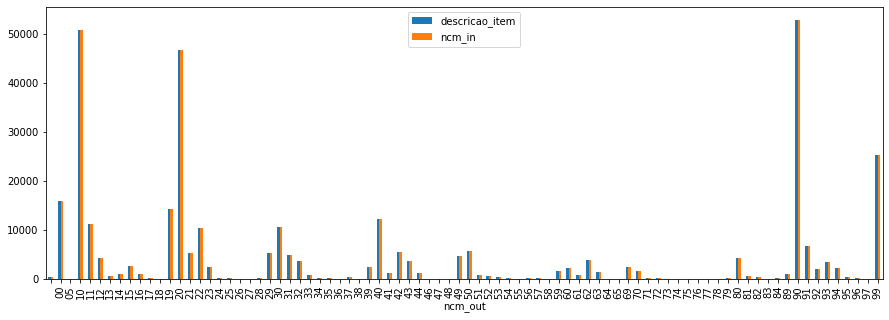

In [38]:
!pip install matplotlib
import matplotlib.pyplot as plt
df_group = df.groupby('ncm_out').count()
df_group
df_group.plot.bar( figsize=(15, 5))

In [39]:
over5000 = []
median = []
less1000 = []

for i in range(len(df_group)):
    if df_group['descricao_item'].iloc[i] > 1000:
        over5000.append(df_group['descricao_item'].index[i])
    elif df_group['descricao_item'].iloc[i] < 100:
        less1000.append(df_group['descricao_item'].index[i])
    else:
        median.append(df_group['descricao_item'].index[i])

In [40]:
print(f"acima de 1000 amostras {len(over5000)}\nentre 1000 e 100 {len(median)}\nabaixo de 100 {len(less1000)}")


acima de 1000 amostras 35
entre 1000 e 100 20
abaixo de 100 29


In [41]:
len(df)

343240

In [42]:
#DROP menores que 1000
for i in less1000:
   df.drop(df.loc[df['ncm_out'] == i].index, inplace=True)

In [43]:
len(df)

342500

In [44]:
import pandas as pd
import numpy as np


for i in over5000: 
    remove_n = len(df.loc[df['ncm_out'] == i ]) - 1000
    remove_class = i
    # Here you first find the indexes where class is equal to the class you want to drop.
    #Then you slice only the first n indexes of this class
    index_to_drop = df.index[df['ncm_out'] == remove_class][:remove_n]
    #Finally drop those indexes
    df = df.drop(index_to_drop)

In [45]:
df = df.reset_index()
df

,index,descricao_item,ncm_in,ncm_out
0,1187,14421 DNI RELE AUXILIAR C SUPORTE A V,8413,81
1,1231,226 PK CORREIA ALTERNADOR GIR ALT BA ACD,4010,33
2,1386,209 CA32 AF JOGO LONA FREIO TRASEIRO L,6813,81
3,1441,2506 PORCA COMPLETAR ANEL OSCILANTE CH MM,7318,16
4,1446,PORCA SUPER ALTA COMPLETAR ANEL OSCILANT,7318,16
...,...,...,...,...
44322,343242,ZIN E MAQUINA DO VIDRO ESQUERDA PINO ALTO,8708,29
44323,343243,"ZINCO 100CM 3,50KG P MT CP",7210,49
44324,343244,ZMM 9010811 ALTERNADOR 12V AMP,8511,50
44325,343245,ZORDS COM FIGURA E,9503,00


In [46]:
df = df.drop(columns=['index',])

<AxesSubplot:xlabel='ncm_out'>

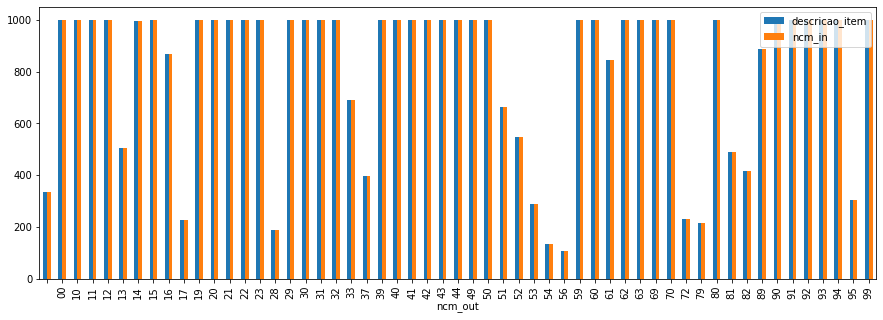

In [47]:
df_group_nw = df.groupby('ncm_out').count()
df_group_nw
df_group_nw.plot.bar( figsize=(15, 5))

In [48]:
palavras_final = []
for i in range(len(df['descricao_item'])): 
    produto = df['descricao_item'].iloc[i]
    from string import punctuation
    sentencas = nltk.sent_tokenize(produto)
    palavras = nltk.word_tokenize(produto.upper())
    stemmer = nltk.stem.RSLPStemmer()
    palavras_stem = []
    for palavra in palavras:
        palavras_stem.append(stemmer.stem(palavra))
    palavras_sem_stopwords = [palavras_stem for palavras_stem in palavras_stem if palavras_stem not in stopwords]
    palavra_final = ' '.join(palavras_sem_stopwords)
    palavras_final.append(palavra_final)
x = pd.Series(palavras_final)
df['descricao_item_clean'] = x

In [49]:
df.dropna()
df.drop(df.loc[df['ncm_out'] == ''].index, inplace=True)

In [50]:
data = [df["descricao_item_clean"], df["ncm_in"]]

headers = ["descricao", "ncm_in"]

df_n = pd.concat(data, axis=1, keys=headers)


In [51]:
from sklearn.preprocessing import LabelEncoder

labels_enc = LabelEncoder()
labels_enc.fit(df_n['ncm_in'])
x_train_lables_trf = labels_enc.transform(df_n['ncm_in'])
df_n['ncm_in'] = x_train_lables_trf

In [52]:
!pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


labels = df['ncm_out']
text = df_n

X_train, X_test, y_train, y_test = train_test_split(text, labels, random_state=0, test_size=0.2)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.descricao)
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_transformed = tf_transformer.transform(X_train_counts)

X_test_counts = count_vect.transform(X_test.descricao)
X_test_transformed = tf_transformer.transform(X_test_counts)

labels_enc = LabelEncoder()
y_train_labels_fit = labels_enc.fit(y_train)
y_train_lables_trf = labels_enc.transform(y_train)



#print(labels.classes_)

In [53]:
import scipy.sparse as sp
X_position_train = np.atleast_2d(X_train.ncm_in.astype(int)).T
X_train = sp.hstack((X_train_transformed, X_position_train))

X_position_test = np.atleast_2d(X_test.ncm_in.astype(int)).T
X_test = sp.hstack((X_test_transformed, X_position_test))

In [54]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
clf = linear_svc.fit(X_train,y_train)

C:\Users\Pedro\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [55]:
from sklearn import metrics
import numpy as np
y_test = y_test.astype(int)
#p_count = count_vect.transform(list(X_test))
#p_tfidf = tf_transformer.transform(p_count)
y_pred = clf.predict(X_test)
y_pred = list(map(int, y_pred))
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.45      0.23      0.30       218
          10       0.41      0.29      0.34       195
          11       0.58      0.42      0.49       219
          12       0.61      0.50      0.55       201
          13       0.62      0.58      0.60       118
          14       0.64      0.78      0.71       206
          15       0.76      0.62      0.69       215
          16       0.80      0.85      0.82       176
          17       0.56      0.58      0.57        50
          19       0.40      0.44      0.42       195
          20       0.43      0.40      0.41       184
          21       0.32      0.46      0.38       229
          22       0.58      0.73      0.65       196
          23       0.59      0.73      0.65       190
          28       0.78      0.43      0.55        42
          29       0.34      0.30      0.32       219
          30       0.49      0.20      0.28       213
          31       0.73    

C:\Users\Pedro\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
